## Multiclass Feature Selection

### Imports

In [29]:
import warnings

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


warnings.filterwarnings('ignore')

### Dataset

#### Note: The column Multiclass should be added to the dataset before processing this step. (The dataset include Multiclass column was created with AddMulticlassColumn.py)

In [15]:
df = pd.read_csv('data/train_multiclass.csv')

In [16]:
df.columns

Index(['ID', 'flow_duration', 'Header_Length', 'Protocol type', 'Duration',
       'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'Label',
       'Multiclass'],
      dtype='object')

In [17]:
df['Multiclass'].value_counts()

Multiclass
DDoS          876708
DoS           302825
Mirai         251721
Recon         240063
Spoofing      168006
Benign         84085
Web            15265
BruteForce      9213
Malware         2252
Name: count, dtype: int64

### Delete 'Label' column

In [18]:
df = df.drop(columns=['ID', 'Label'])

In [19]:
df.shape

(1950138, 47)

In [20]:
df.columns

Index(['flow_duration', 'Header_Length', 'Protocol type', 'Duration', 'Rate',
       'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number',
       'rst_flag_number', 'psh_flag_number', 'ack_flag_number',
       'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count',
       'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet',
       'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC',
       'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number',
       'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight', 'Multiclass'],
      dtype='object')

### Label Encoder for multiclass

In [22]:
enc = LabelEncoder()
df['Multiclass'] = enc.fit_transform(df['Multiclass'])

In [23]:
df['Multiclass'].value_counts()

Multiclass
2    876708
3    302825
5    251721
6    240063
7    168006
0     84085
8     15265
1      9213
4      2252
Name: count, dtype: int64

In [25]:
enc.classes_

array(['Benign', 'BruteForce', 'DDoS', 'DoS', 'Malware', 'Mirai', 'Recon',
       'Spoofing', 'Web'], dtype=object)

### Feature selection with Random Forest

In [26]:
x = df.drop(columns=['Multiclass'])
y = df['Multiclass']

In [27]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
# Fit on training data
scaler.fit(x)
X = scaler.transform(x)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
rf = RandomForestClassifier()

In [32]:
rf.fit(X, y)

RandomForestClassifier()

In [33]:
rf_importances = rf.feature_importances_

In [34]:
sorted_indices_rf = rf_importances.argsort()[::-1]

In [35]:
top_25_indices_rf = sorted_indices_rf[:25]

In [36]:
feature_names = x.columns
top_25_features_rf = [feature_names[i] for i in top_25_indices_rf]

# Print the top 25 feature names from Random Forest
print("Top 25 features from Random Forest:")
for feature in top_25_features_rf:
    print(feature)

Top 25 features from Random Forest:
IAT
Min
AVG
Protocol type
flow_duration
rst_count
Number
Weight
urg_count
Tot size
Header_Length
Magnitue
Tot sum
Variance
Max
Rate
Srate
Duration
Std
syn_count
Radius
Covariance
fin_count
ack_flag_number
UDP


In [37]:
score_rf = pd.DataFrame({
    'Feature': feature_names,
    'RF Importance': rf_importances
})

score_rf = score_rf.sort_values(by='RF Importance', ascending=False)

top_25_features_rf = score_rf.head(25)
top_25_features_rf

,Feature,RF Importance
39,IAT,0.258204
34,Min,0.061476
36,AVG,0.055710
2,Protocol type,0.053421
0,flow_duration,0.044813
18,rst_count,0.044170
40,Number,0.041063
45,Weight,0.038889
17,urg_count,0.036476
38,Tot size,0.035059


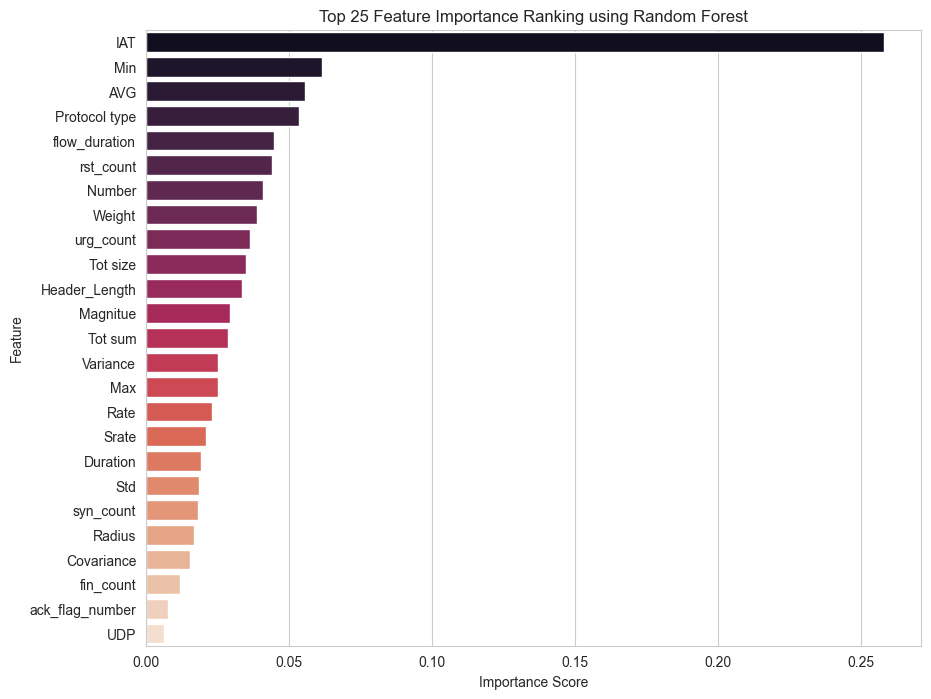

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

top_25 = top_25_features_rf.sort_values(by='RF Importance', ascending=False)

sns.set_style("whitegrid")

plt.figure(figsize=(10, 8))
sns.barplot(x='RF Importance', y='Feature', data=top_25, palette='rocket')

plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Top 25 Feature Importance Ranking using Random Forest')

plt.show()

In [39]:
unselected_rf = score_rf[~score_rf['Feature'].isin(top_25_features_rf['Feature'])]
unselected_rf_array = unselected_rf['Feature'].values
unselected_rf_array

array(['ack_count', 'HTTP', 'TCP', 'HTTPS', 'ICMP', 'syn_flag_number',
       'psh_flag_number', 'fin_flag_number', 'rst_flag_number', 'SSH',
       'DNS', 'LLC', 'IPv', 'ARP', 'ece_flag_number', 'Drate',
       'cwr_flag_number', 'IRC', 'DHCP', 'SMTP', 'Telnet'], dtype=object)